# APISR 官方预训练模型推理脚本 (Inference)

本 Notebook 用于加载 APISR 官方提供的预训练 ESRGAN 模型 (`4x_APISR_RRDB_GAN_generator.pth`)，在你的自定义数据集上进行推理，并将结果保存到 `results/APISR_ESRGAN_inference` 目录下，以便与你微调后的模型进行对比。

In [1]:
import os
import sys
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

# 将本地的 APISR_tools 目录添加到系统路径
apisr_tools_path = os.path.abspath('APISR_tools')
if apisr_tools_path not in sys.path:
    sys.path.append(apisr_tools_path)

# 导入 RRDBNet 架构
from architecture.rrdb import RRDBNet

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

PyTorch Version: 2.9.0+cu130
CUDA Available: True


In [2]:
# ==========================================
# 1. 配置参数
# ==========================================

# 模型路径 (APISR 官方预训练模型)
MODEL_PATH = 'pretrained_models/4x_APISR_RRDB_GAN_generator.pth'

# 测试图像路径
LR_DIR = 'dataset/lowres/original'
HR_DIR = 'dataset/highres/original'
OUTPUT_DIR = 'results/APISR_ESRGAN_inference'

# 放大倍数
SCALE = 4

# 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# ==========================================
# 2. 加载模型
# ==========================================

# 实例化生成器 (RRDBNet)
# APISR 官方模型使用的是 6 个 block (根据报错信息，缺少 body.6 到 body.22 的权重)
model = RRDBNet(3, 3, scale=SCALE, num_block=6).to(device)

# 加载权重
print(f"正在加载模型权重: {MODEL_PATH}")
checkpoint = torch.load(MODEL_PATH, map_location=device)

# 提取模型状态字典 (APISR 官方权重通常保存在 params_ema 中)
if 'params_ema' in checkpoint:
    model.load_state_dict(checkpoint['params_ema'], strict=True)
    print("成功加载 params_ema 权重。")
elif 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'], strict=True)
    print("成功加载 model_state_dict 权重。")
else:
    model.load_state_dict(checkpoint, strict=True)
    print("成功加载权重。")

# 设置为评估模式
model.eval()

正在加载模型权重: pretrained_models/4x_APISR_RRDB_GAN_generator.pth
成功加载 model_state_dict 权重。


RRDBNet(
  (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (body): Sequential(
    (0): RRDB(
      (rdb1): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (rdb2): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), 

In [4]:
# ==========================================
# 3. 推理与可视化函数 (分块推理防爆显存)
# ==========================================

def tensor2img(tensor):
    """将 PyTorch Tensor 转换为 numpy 图像 (RGB, 0-255)"""
    img = tensor.squeeze(0).cpu().numpy()
    img = np.transpose(img, (1, 2, 0)) # CHW -> HWC
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    return img

def infer_and_save(lr_path, hr_path=None, save_dir=None, show=True):
    """对单张图像进行推理，保存并可选择显示对比图"""
    # 1. 读取 LR 图像
    lr_img = cv2.imread(lr_path)
    if lr_img is None:
        print(f"无法读取图像: {lr_path}")
        return None
    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
    
    # 2. 预处理 (转为 Tensor, 归一化到 [0, 1], 增加 Batch 维度)
    lr_tensor = torch.from_numpy(lr_img.transpose(2, 0, 1)).float() / 255.0
    lr_tensor = lr_tensor.unsqueeze(0).to(device)
    
    # 3. 模型推理 (使用分块推理防止 OOM)
    with torch.no_grad():
        with torch.amp.autocast('cuda'): # 开启混合精度加速推理
            _, _, h, w = lr_tensor.shape
            
            if h * w > 512 * 512:
                # 简单的 2x2 分块推理
                h_half, w_half = h // 2, w // 2
                
                # 预分配输出 Tensor
                sr_tensor = torch.zeros((1, 3, h * SCALE, w * SCALE), device=device)
                
                # 左上
                sr_tensor[:, :, :h_half*SCALE, :w_half*SCALE] = model(lr_tensor[:, :, :h_half, :w_half])
                # 右上
                sr_tensor[:, :, :h_half*SCALE, w_half*SCALE:] = model(lr_tensor[:, :, :h_half, w_half:])
                # 左下
                sr_tensor[:, :, h_half*SCALE:, :w_half*SCALE] = model(lr_tensor[:, :, h_half:, :w_half])
                # 右下
                sr_tensor[:, :, h_half*SCALE:, w_half*SCALE:] = model(lr_tensor[:, :, h_half:, w_half:])
            else:
                # 图像较小，直接推理
                sr_tensor = model(lr_tensor)
            
    # 4. 后处理
    sr_img = tensor2img(sr_tensor)
    
    # 5. 保存图像
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        filename = os.path.basename(lr_path)
        save_path = os.path.join(save_dir, filename)
        # OpenCV 保存需要 BGR 格式
        cv2.imwrite(save_path, cv2.cvtColor(sr_img, cv2.COLOR_RGB2BGR))
    
    # 6. 可视化
    if show:
        if hr_path and os.path.exists(hr_path):
            hr_img = cv2.imread(hr_path)
            hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
            
            h, w, _ = hr_img.shape
            lr_resized = cv2.resize(lr_img, (w, h), interpolation=cv2.INTER_CUBIC)
            
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            axes[0].imshow(lr_resized)
            axes[0].set_title('LR (Bicubic Upscaled)')
            axes[0].axis('off')
            
            axes[1].imshow(sr_img)
            axes[1].set_title('SR (APISR Output)')
            axes[1].axis('off')
            
            axes[2].imshow(hr_img)
            axes[2].set_title('HR (Ground Truth)')
            axes[2].axis('off')
            
        else:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(lr_img)
            axes[0].set_title('LR Input')
            axes[0].axis('off')
            
            axes[1].imshow(sr_img)
            axes[1].set_title('SR (APISR Output)')
            axes[1].axis('off')
            
        plt.tight_layout()
        plt.show()
        
    return sr_img

开始批量推理，结果将保存至: results/APISR_ESRGAN_inference


Inference Progress:  41%|████      | 177/434 [01:59<01:52,  2.28it/s]


Visualizing: 381386.jpg


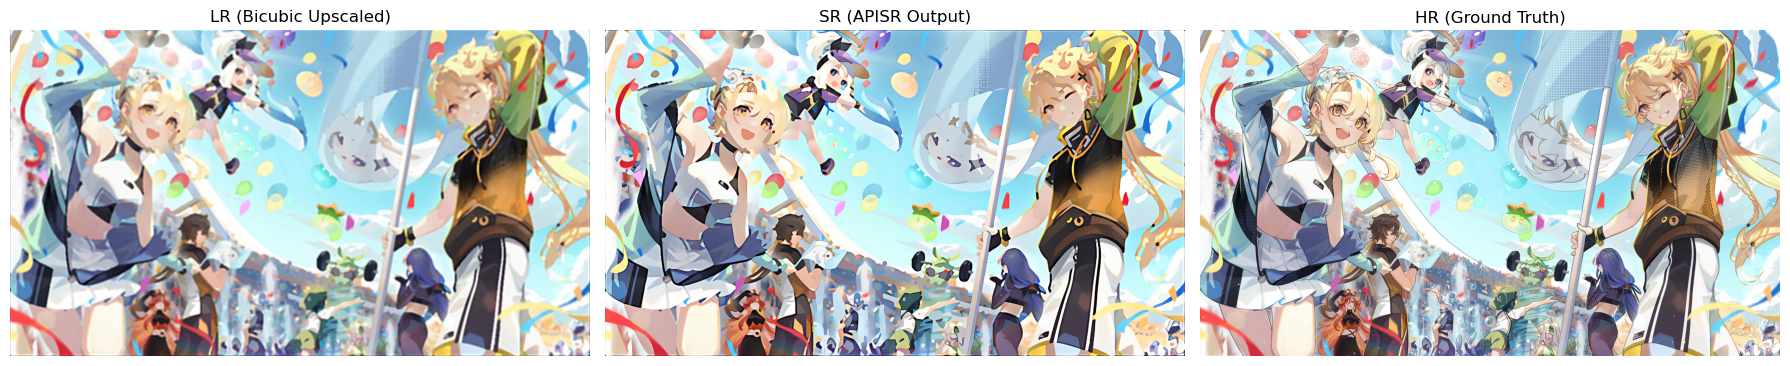

Inference Progress:  45%|████▌     | 197/434 [02:23<02:21,  1.67it/s]


Visualizing: 382152.jpg


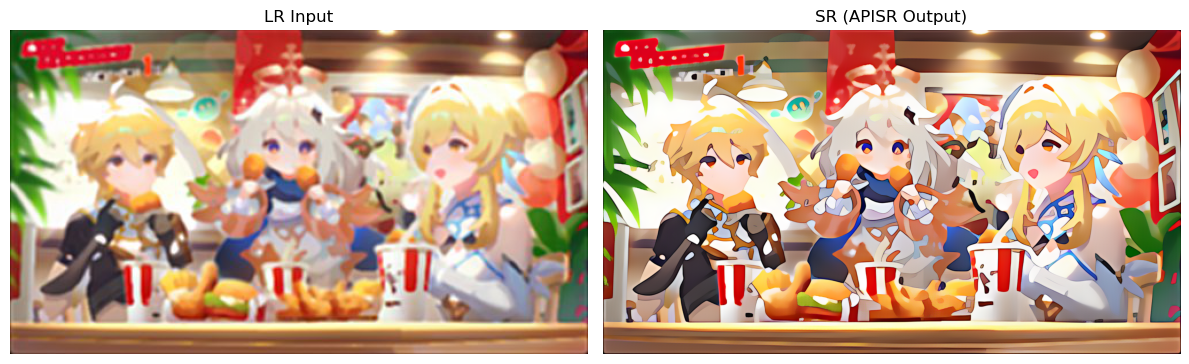

Inference Progress:  87%|████████▋ | 379/434 [05:03<01:06,  1.21s/it]


Visualizing: 395475.jpg


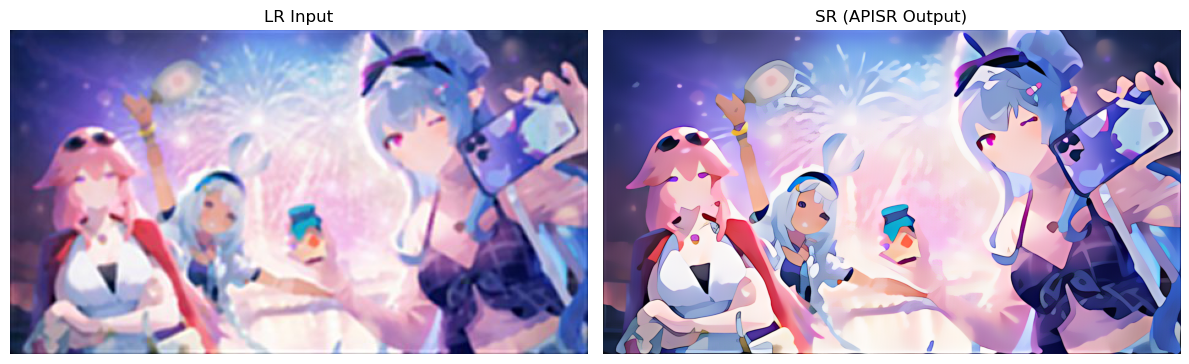

Inference Progress: 100%|██████████| 434/434 [05:42<00:00,  1.27it/s]

批量推理完成！


In [5]:
# ==========================================
# 4. 批量推理并保存
# ==========================================
from tqdm import tqdm

# 获取所有 LR 图像路径
lr_paths = sorted(glob.glob(os.path.join(LR_DIR, '*.*')))
hr_paths = sorted(glob.glob(os.path.join(HR_DIR, '*.*')))

if not lr_paths:
    print("未找到测试图像，请检查路径。")
else:
    print(f"开始批量推理，结果将保存至: {OUTPUT_DIR}")
    # 随机抽取 3 张图像进行可视化展示
    num_samples = min(3, len(lr_paths))
    sample_indices = random.sample(range(len(lr_paths)), num_samples)
    
    for idx, lr_path in enumerate(tqdm(lr_paths, desc="Inference Progress")):
        filename = os.path.basename(lr_path)
        hr_path = os.path.join(HR_DIR, filename)
        
        # 只有被抽中的 3 张图片会显示可视化对比，其他的只保存
        show_vis = (idx in sample_indices)
        if show_vis:
            print(f"\nVisualizing: {filename}")
            
        infer_and_save(lr_path, hr_path=hr_path, save_dir=OUTPUT_DIR, show=show_vis)
        
    print("批量推理完成！")

In [6]:
# ==========================================
# 5. 图像质量评估 (NIQE, MANIQA, CLIPIQA)
# ==========================================
try:
    import pyiqa
except ImportError:
    print("未检测到 pyiqa 库，准备退出。")
    exit()

print("正在初始化评估指标...")
niqe_metric = pyiqa.create_metric('niqe', device=device)
maniqa_metric = pyiqa.create_metric('maniqa', device=device)
clipiqa_metric = pyiqa.create_metric('clipiqa', device=device)

sr_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR, '*.*')))

niqe_scores = []
maniqa_scores = []
clipiqa_scores = []

print("开始评估生成的 SR 图像...")
for sr_path in tqdm(sr_paths, desc="Evaluating"):
    niqe_score = niqe_metric(sr_path).item()
    maniqa_score = maniqa_metric(sr_path).item()
    clipiqa_score = clipiqa_metric(sr_path).item()
    
    niqe_scores.append(niqe_score)
    maniqa_scores.append(maniqa_score)
    clipiqa_scores.append(clipiqa_score)

print("\n" + "="*40)
print("APISR 官方模型评估结果 (Evaluation Results):")
print("="*40)
print(f"Average NIQE   : {np.mean(niqe_scores):.4f} (越低越好, Lower is better)")
print(f"Average MANIQA : {np.mean(maniqa_scores):.4f} (越高越好, Higher is better)")
print(f"Average CLIPIQA: {np.mean(clipiqa_scores):.4f} (越高越好, Higher is better)")
print("="*40)

正在初始化评估指标...


c:\Users\admin\.conda\envs\ece284fa25\Lib\site-packages\timm\models\layers\__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading pretrained model MANIQA from C:\Users\admin\.cache\torch\hub\pyiqa\ckpt_koniq10k.pt
开始评估生成的 SR 图像...


Evaluating: 100%|██████████| 436/436 [11:50<00:00,  1.63s/it] 


APISR 官方模型评估结果 (Evaluation Results):
Average NIQE   : 6.3849 (越低越好, Lower is better)
Average MANIQA : 0.4760 (越高越好, Higher is better)
Average CLIPIQA: 0.6703 (越高越好, Higher is better)
